# OptimizedBot optimization

In [210]:
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter
from tqdm.notebook import trange
from copy import deepcopy
from itertools import combinations
import joblib

sys.path.append('..')
from blockade import Blockade
from players.OptimizedBot import OptimizedBot
from players.HeuristicBot import HeuristicBot
from players.RandomBot import RandomBot

## Testing `arena_size` vs game time relation

Outcomes (and times) for arena_size=10:
2 (0.51s);	1 (0.45s);	1 (0.41s);	0 (0.5s);	1 (0.49s);	1 (0.52s);	2 (0.29s);	2 (0.31s);	1 (0.28s);	1 (0.51s);	
Average time: 0.43s
Outcomes (and times) for arena_size=11:
2 (0.72s);	0 (0.37s);	1 (0.66s);	1 (0.71s);	1 (0.7s);	2 (0.74s);	1 (0.7s);	2 (0.4s);	1 (0.37s);	1 (0.59s);	
Average time: 0.59s
Outcomes (and times) for arena_size=12:
0 (0.47s);	1 (0.68s);	2 (0.45s);	2 (0.5s);	1 (0.93s);	0 (0.94s);	2 (0.46s);	2 (0.51s);	1 (0.48s);	2 (0.51s);	
Average time: 0.59s
Outcomes (and times) for arena_size=13:
2 (1.12s);	0 (0.7s);	1 (0.97s);	0 (1.26s);	0 (1.3s);	2 (0.68s);	0 (0.97s);	1 (1.27s);	1 (1.36s);	2 (0.63s);	
Average time: 1.02s
Outcomes (and times) for arena_size=14:
2 (0.83s);	2 (1.7s);	1 (1.54s);	1 (1.52s);	2 (0.83s);	2 (0.82s);	1 (1.96s);	2 (1.14s);	1 (0.82s);	2 (0.79s);	
Average time: 1.2s
Outcomes (and times) for arena_size=15:
1 (2.23s);	2 (2.34s);	1 (1.04s);	0 (2.06s);	2 (1.02s);	2 (0.98s);	1 (1.95s);	1 (1.99s);	1 (2.42s);	0 (1.36s);	
Ave

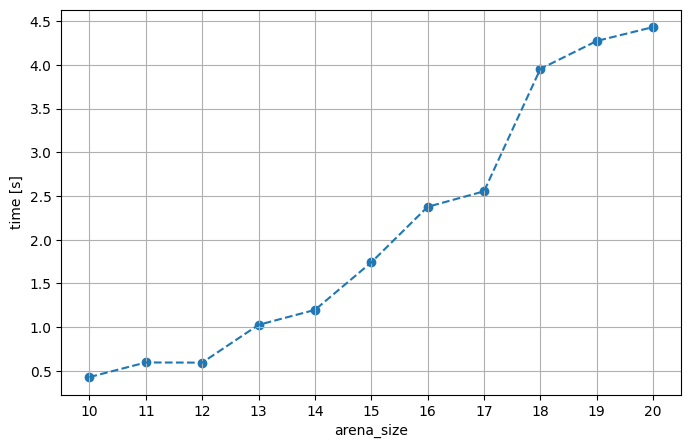

In [8]:
avg_test_run_times = []
arena_sizes = list(range(10, 21))

for arena_size in arena_sizes:
    print(f'Outcomes (and times) for arena_size={arena_size}:')
    test_run_times = []
    for seed in range(10):
        random.seed(seed)

        start = perf_counter()
        game = Blockade(player1=OptimizedBot(weights=[1.0, 1.0, 1.0, 0.0], verbose=False),
                        player2=OptimizedBot(weights=[1.0, 1.0, 1.0, 0.0], verbose=False),
                        arena_size=arena_size,
                        verbose=False)
        outcome = game.run_windowless()
        stop = perf_counter()
        test_run_times.append(stop-start)
        print(f'{outcome} ({np.round(test_run_times[-1], 2)}s);\t', end='')

    avg_test_run_times.append(np.mean(test_run_times))
    print(f'\nAverage time: {np.round(avg_test_run_times[-1], 2)}s')
    
plt.figure(figsize=(8, 5))
plt.scatter(arena_sizes, avg_test_run_times)
plt.plot(arena_sizes, avg_test_run_times, linestyle='--')
plt.grid()
plt.xticks(arena_sizes)
plt.xlabel('arena_size')
plt.ylabel('time [s]')
plt.show()
plt.close()

Conclusion: lower `arena_size` should be used to speed-up optimization. Let's use `arena_size=15` as a compromise.

## Evolutionary optimization

In [177]:
def init_random_population(num_weights, pop_size):
    return [np.random.random(num_weights) * 2 - 1 for _ in range(pop_size)]

def crossover(individual1, individual2):
    # averaging crossover
    return np.mean([individual1, individual2], axis=0)

def reflected_normal_distribution(loc, scale, min_val=-1.0, max_val=1.0):
    # safely get a number from normal distribution
    # in case the value is out of the allowed scope, use the fractional part to get the closest allowed value
    base_val = np.random.normal(loc, scale)
    if base_val < min_val:
        fractional_part = base_val % min_val
        return min(fractional_part, min_val - fractional_part)
    elif base_val > max_val:
        fractional_part = base_val % max_val
        return max(fractional_part, max_val - fractional_part)
    else:
        return base_val

def mutation(individual, prob, scale):
    # gaussian mutation with reflection
    return np.array([(reflected_normal_distribution(weight, scale) if np.random.random() < prob else weight) for weight in individual])

def tournament_selection(participants, arena_size, repetitions, score_dict, recursion_depth=2):
    # true football-style tournament
    scores = np.zeros(len(participants))
    for rep in range(repetitions):
        for p1, p2 in combinations(list(range(len(participants))), 2):
            if rep % 2:
                # switch sides every second repetition
                p1, p2 = p2, p1
            game = Blockade(player1=OptimizedBot(weights=participants[p1], verbose=False),
                            player2=OptimizedBot(weights=participants[p2], verbose=False),
                            arena_size=arena_size,
                            verbose=False)
            outcome = game.run_windowless()
            if outcome == 1:
                scores[p1] += score_dict['won']
                scores[p2] += score_dict['lost']
            elif outcome == 2:
                scores[p1] += score_dict['lost']
                scores[p2] += score_dict['won']
            else:
                scores[p1] += score_dict['drew']
                scores[p2] += score_dict['drew']

    best_participants = np.argwhere(scores == np.amax(scores))
    if len(best_participants) > 1 and recursion_depth > 0:
        # perform an additional mini-tournament without repetitions in case of a tie (limited by recursion_depth)
        tied_best_participants = [participants[int(i)] for i in best_participants]
        return tournament_selection(tied_best_participants, arena_size, 1, score_dict, recursion_depth-1)
    else:
        return participants[int(best_participants[0])]

In [180]:
np.random.seed(42)

# evolution parameters
num_weights = 4
pop_size = 15
num_generations = 50
mutation_prob = 0.5
mutation_scale = 0.1
tournament_size = 5
arena_size = 15
tournament_repetitions = 2
tournament_score_dict = {'won': 3, 'lost': 0, 'drew': 1}

# custom evolutionary algorithm
weight_history = [[[] for _ in range(num_generations)] for _ in range(num_weights)] # only used for plotting history
population = init_random_population(num_weights, pop_size)
for generation in trange(num_generations):
    # save weights
    for individual in population:
        for i in range(num_weights):
            weight_history[i][generation].append(individual[i])
    
    # crossover & mutation
    child_population = []
    while len(child_population) < pop_size:
        parents = np.random.choice(list(range(pop_size)), 2, replace=False)
        child = crossover(population[int(parents[0])], population[int(parents[1])])
        mutated_child = mutation(child, mutation_prob, mutation_scale)
        child_population.append(mutated_child)
    
    # tournament selection out of joined parent and child population
    new_population = []
    joined_populations = population + child_population
    if len(joined_populations) != pop_size * 2:
        print(f'ERROR: wrong tournament size: {len(joined_populations)} (should be {pop_size * 2})')
        break
    while len(new_population) < pop_size:
        tournament_participants = [joined_populations[i] for i in np.random.choice(list(range(pop_size * 2)), tournament_size, replace=False)]
        tournament_winner = tournament_selection(tournament_participants, arena_size, tournament_repetitions, tournament_score_dict)
        new_population.append(tournament_winner)
    
    # replace population
    population = new_population

# select the final best solution in another tournament
best_solution = tournament_selection(population, arena_size, tournament_repetitions, tournament_score_dict)
print('Best solution:')
print(best_solution)

  0%|          | 0/50 [00:00<?, ?it/s]

Best solution:
[ 0.25648373 -0.31488939 -0.12317508  0.48541348]


In [198]:
# save weight history
joblib.dump(weight_history, 'weight_history.gz', compress=True)

['weight_history.gz']

## Show evolution history

In [199]:
# load weight history
weight_history = joblib.load('weight_history.gz')

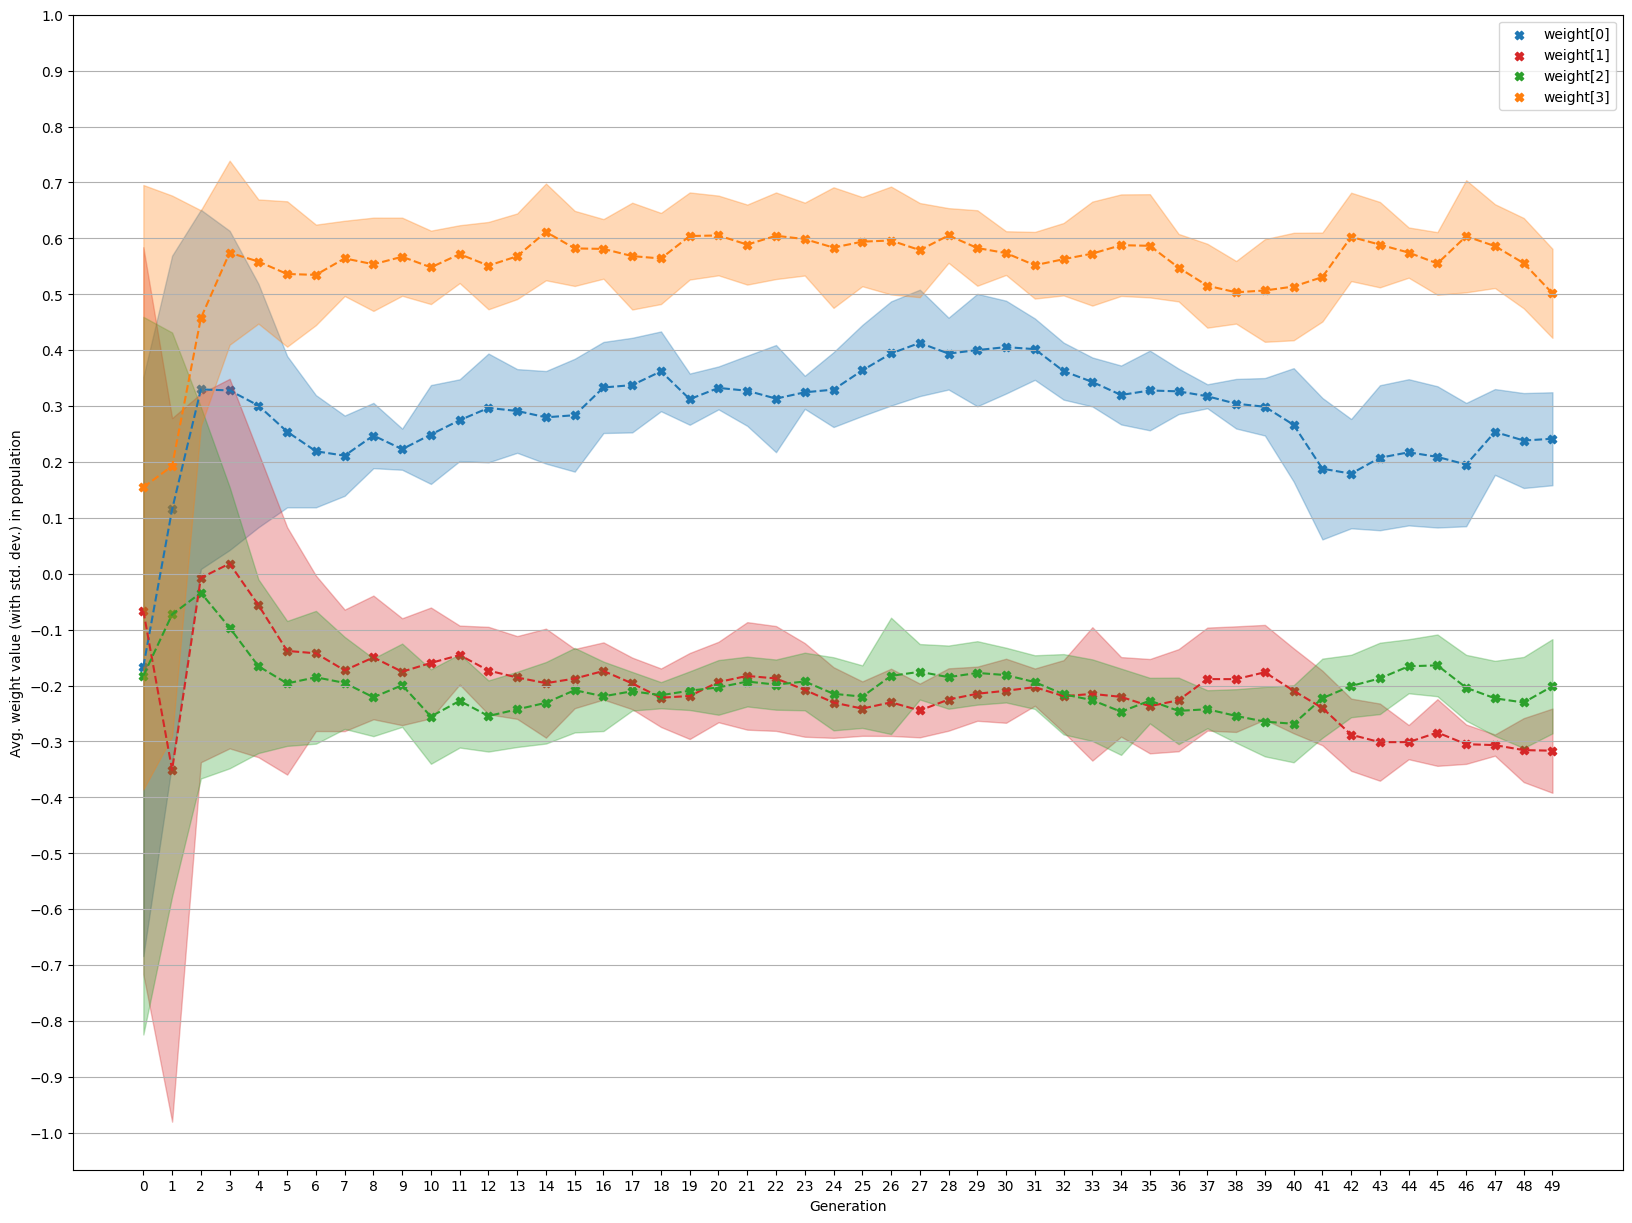

In [201]:
plt.figure(figsize=(20, 15))
generations = list(range(num_generations))
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange']
for i, weight_list in enumerate(weight_history):
    avgs = np.mean(weight_list, axis=1)
    stds = np.std(weight_list, axis=1)
    plt.scatter(generations, avgs, c=colors[i], marker='X', label=f'weight[{i}]')
    plt.plot(generations, avgs, c=colors[i], linestyle='--')
    plt.fill_between(generations, avgs + stds, avgs - stds, color=colors[i], alpha=0.3)

plt.xlabel('Generation')
plt.ylabel('Avg. weight value (with std. dev.) in population')
plt.xticks(ticks=generations)
plt.yticks(ticks=list(np.round(np.arange(-1.0, 1.1, 0.1), 2)))
plt.legend(loc='upper right')
plt.grid(axis='y')
plt.savefig('avg-weight-evolution.png', bbox_inches='tight', pad_inches=0.3)
plt.show()
plt.close()

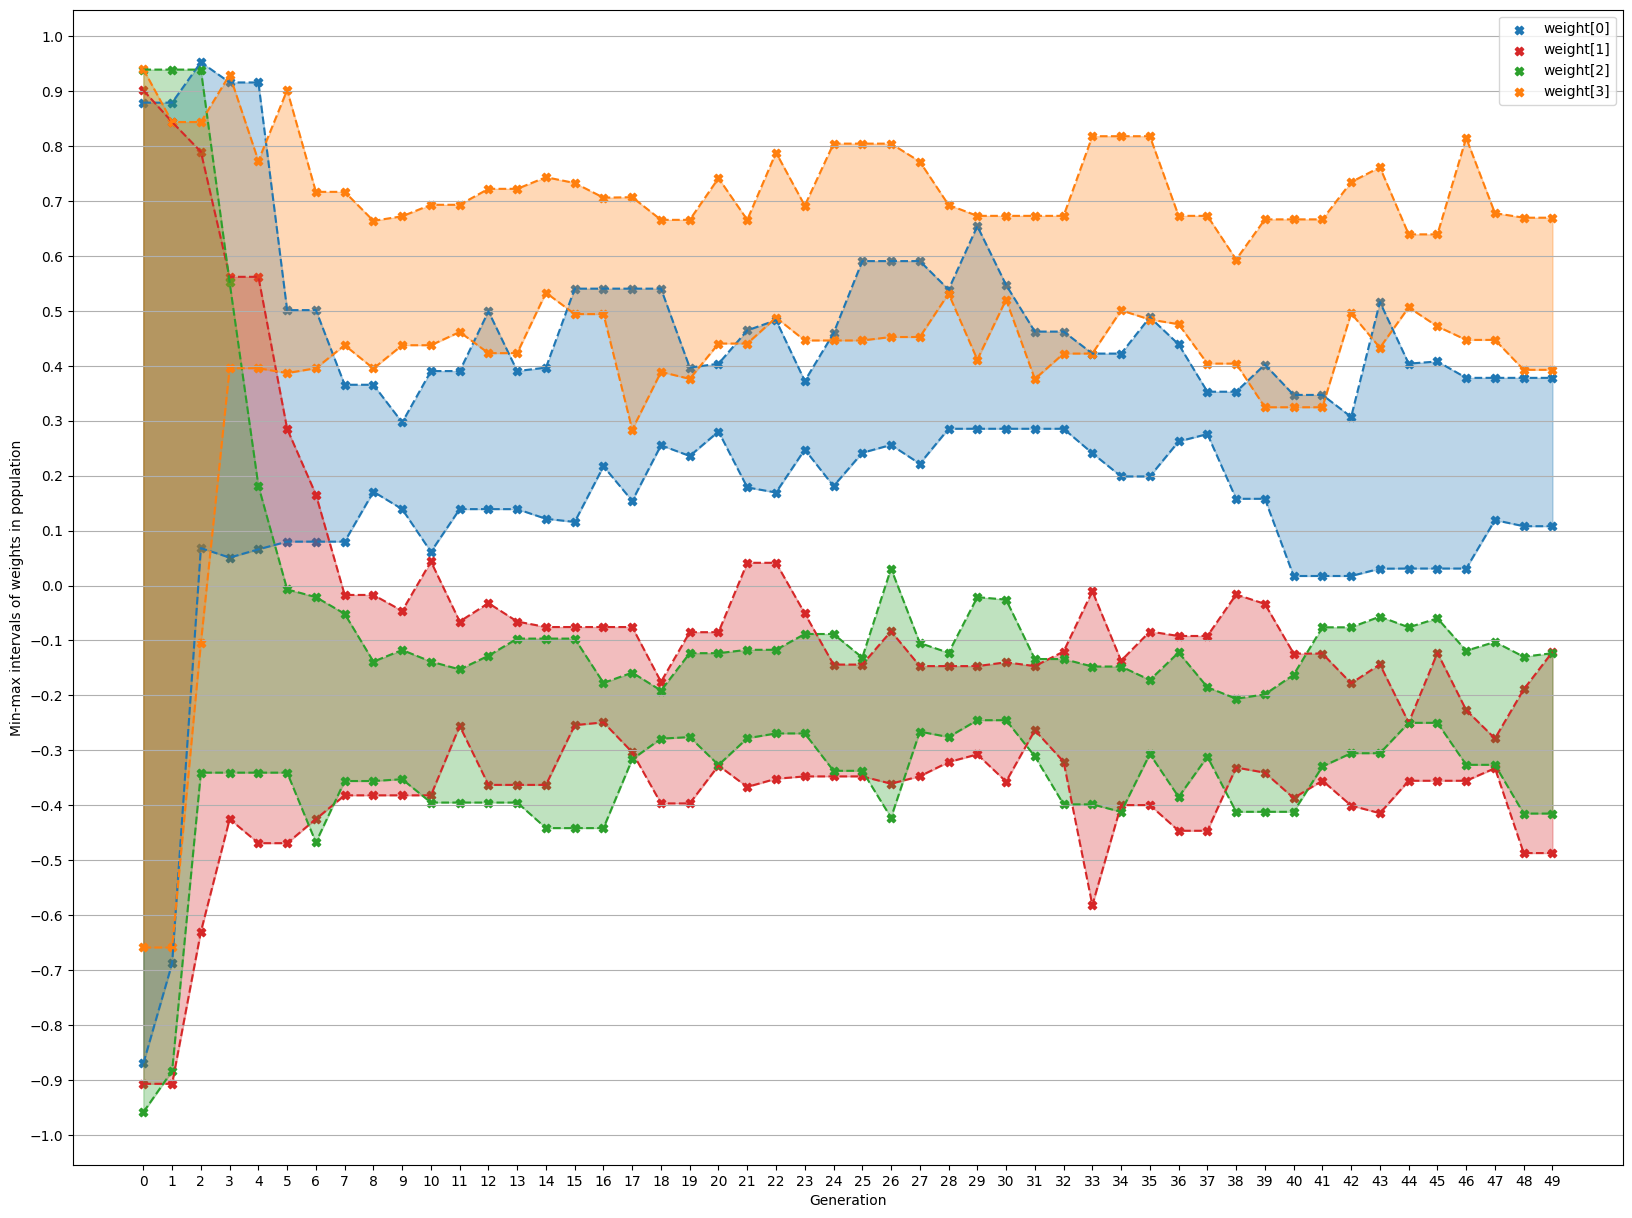

In [202]:
plt.figure(figsize=(20, 15))
generations = list(range(num_generations))
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange']
for i, weight_list in enumerate(weight_history):
    maxs = np.max(weight_list, axis=1)
    mins = np.min(weight_list, axis=1)
    plt.scatter(generations, maxs, c=colors[i], marker='X', label=f'weight[{i}]')
    plt.plot(generations, maxs, c=colors[i], linestyle='--')
    plt.scatter(generations, mins, c=colors[i], marker='X')
    plt.plot(generations, mins, c=colors[i], linestyle='--')
    plt.fill_between(generations, maxs, mins, color=colors[i], alpha=0.3)

plt.xlabel('Generation')
plt.ylabel('Min-max intervals of weights in population')
plt.xticks(ticks=generations)
plt.yticks(ticks=list(np.round(np.arange(-1.0, 1.1, 0.1), 2)))
plt.legend(loc='upper right')
plt.grid(axis='y')
plt.savefig('min-max-weight-evolution.png', bbox_inches='tight', pad_inches=0.3)
plt.show()
plt.close()

## Compare OptimizedBot against other bots

In [231]:
def make_bot_comparison(bot1, bot2, arena_size=15, num_seeds=1000, repetitions=2):
    opt_win_counter = 0
    draw_counter = 0
    for seed in trange(num_seeds):
        for rep in range(repetitions):
            random.seed(seed)
            p1 = bot1
            p2 = bot2
            if rep % 2:
                p1, p2 = p2, p1
            game = Blockade(player1=p1,
                            player2=p2,
                            arena_size=arena_size,
                            verbose=False)
            outcome = game.run_windowless()
            if (p1 == bot1 and outcome == 1) or (p2 == bot1 and outcome == 2):
                opt_win_counter += 1
            elif outcome == 0:
                draw_counter += 1

    print(f'{bot1} against {bot2} results (arena_size={arena_size}):')
    total_games = num_seeds * repetitions
    lost_games = total_games - opt_win_counter - draw_counter
    print(f'{opt_win_counter}/{total_games} games won ({np.round(opt_win_counter / total_games * 100.0, 2)}%)')
    print(f'{draw_counter}/{total_games} draws ({np.round(draw_counter / total_games * 100.0, 2)}%)')
    print(f'{lost_games}/{total_games} games lost ({np.round(lost_games / total_games * 100.0, 2)}%)')

In [221]:
make_bot_comparison(OptimizedBot(weights=[0.25648373, -0.31488939, -0.12317508, 0.48541348], verbose=False), RandomBot(verbose=False))

  0%|          | 0/1000 [00:00<?, ?it/s]

OptimizedBot [0.25648373, -0.31488939, -0.12317508, 0.48541348] against RandomBot results (arena_size=15):
1634/2000 games won (81.7%)
264/2000 draws (13.2%)
102/2000 games lost (5.1%)


In [222]:
make_bot_comparison(OptimizedBot(weights=[0.25648373, -0.31488939, -0.12317508, 0.48541348], verbose=False), HeuristicBot(verbose=False))

  0%|          | 0/1000 [00:00<?, ?it/s]

OptimizedBot [0.25648373, -0.31488939, -0.12317508, 0.48541348] against HeuristicBot results (arena_size=15):
549/2000 games won (27.45%)
482/2000 draws (24.1%)
969/2000 games lost (48.45%)


In [233]:
make_bot_comparison(HeuristicBot(verbose=False), RandomBot(verbose=False))

  0%|          | 0/1000 [00:00<?, ?it/s]

HeuristicBot against RandomBot results (arena_size=15):
1706/2000 games won (85.3%)
214/2000 draws (10.7%)
80/2000 games lost (4.0%)


Conclusions for `OptimizedBot` with weights `[0.25648373, -0.31488939, -0.12317508, 0.48541348]`: 
* Results against `RandomBot` are similar to `HeuristicBot`'s.
* Results against `HeuristicBot` are underwhelming. Further optimization might be needed.